In [1]:
# !pip3 install opencv-python

In [2]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format

In [1]:
# Import required packages
import numpy as np
import cv2
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Dropout, Flatten, concatenate
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D

import time
import pickle

## 1. Load the datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))

# for i in range(n_img):
#     img_fn = f'../data/train_data/images/{i+1:05d}.png' # I changed the path
#     imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)


# import zipfile
a = {}
zip_file = zipfile.ZipFile('/content/drive/MyDrive/data/train_data/imgs.npy.zip')
imgs = np.load(zip_file.open(zip_file.namelist()[0]))

# load the labels
clean_labels = np.genfromtxt('/content/drive/MyDrive/data/train_data/clean_labels.csv', delimiter=',', dtype="int8") # I changed the path
noisy_labels = np.genfromtxt('/content/drive/MyDrive/data/train_data/noisy_labels.csv', delimiter=',', dtype="int8") # I changed the path

# imgs

## 2. label cleaning model

In [9]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [10]:
X_50000, Y_noisy_50000 = preprocess_data(imgs, noisy_labels)

In [11]:
Y_clean_10000 = K.utils.to_categorical(clean_labels)

In [13]:
# feature model
# weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
feature_model = K.applications.DenseNet201(include_top=False,   # feature extractor
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=1000) 

74850304/74836368 [==============================] - 1s 0us/step


In [14]:
# X_feature = feature_model.predict(imgs[:100])
# print(X_feature.shape)

create a two branch model where one branch consists of feature extractor layers and another one is simply one or more dense layers on top of each other

In [25]:
# branch 1: feature model
img_input = K.Input(shape=(32,32,3))
branch_1 = feature_model
branch_1 = Dense(128, activation="linear")(branch_1.output)

# branch 2: linear
noisy_labels_input = K.Input(shape=(10,))
branch_2 = Dense(128, activation="linear")(noisy_labels_input)
branch_2 = Model(inputs=noisy_labels_input, outputs=branch_2)

# concatenate
concat = concatenate([branch_1, branch_2.output])

# merge two branches
final_model = Dense(64, activation="linear")(concat)
final_model = Dropout(0.25)(final_model)
final_model = Dense(10, activation="softmax")(final_model)

label_correction_model = Model(inputs=[feature_model.input, branch_2.input], outputs=final_model)

In [26]:
label_correction_model.compile(
    optimizer=K.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [27]:
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as ''
checkpoint = K.callbacks.ModelCheckpoint('label_correction_model',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [30]:
# document the start time
start = time.time()

# Fit the model using all data
history = label_correction_model.fit([X_50000[:10000], Y_noisy_50000[:10000]], 
                                     Y_clean_10000,
                                     epochs = 10, 
                                     validation_split = 0.2,
                                     shuffle=True,
                                     callbacks=[lr_reduce, early_stop, checkpoint],
                                     verbose=1)

# document the training stop time
stop = time.time()
label_correction_model_trainingtime = stop - start
print(f"Training time: {label_correction_model_trainingtime}s") # prints: Training time

# Save the entire model as a SavedModel.
label_correction_model.save(f'/content/drive/MyDrive/Colab Notebooks/5243/saved_model/label_correction_model_0')

#import pickle
with open('/content/drive/MyDrive/Colab Notebooks/5243/label_correction_model_trainingtime', 'wb') as fp:
    pickle.dump(label_correction_model_trainingtime, fp)
with open('/content/drive/MyDrive/Colab Notebooks/5243/label_correction_model_historyfit', 'wb') as fp:
    pickle.dump(history, fp)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.7045
Epoch 1: val_accuracy improved from -inf to 0.88500, saving model to label_correction_model
INFO:tensorflow:Assets written to: label_correction_model/assets
250/250 [==============================] - 440s 2s/step - loss: 1.3856 - accuracy: 0.7045 - val_loss: 0.4575 - val_accuracy: 0.8850 - lr: 1.0000e-04
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.9160
Epoch 2: val_accuracy improved from 0.88500 to 0.90250, saving model to label_correction_model
INFO:tensorflow:Assets written to: label_correction_model/assets
250/250 [==============================] - 393s 2s/step - loss: 0.3047 - accuracy: 0.9160 - val_loss: 0.4170 - val_accuracy: 0.9025 - lr: 1.0000e-04
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9569
Epoch 3: val_accuracy did not improve from 0.90250
250/250 [==============================] - 306

In [4]:
# load the model
label_correction_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/5243/saved_model/label_correction_model_0')
#label_correction_model.summary()

In [5]:
# read the variable back
with open('/content/drive/MyDrive/Colab Notebooks/5243/label_correction_model_historyfit', 'rb') as f:
    lc_history = pickle.load(f)

In [18]:
# with open('/content/drive/MyDrive/Colab Notebooks/5243/label_correction_model_trainingtime', 'rb') as f:
#     lc_trainingtime = pickle.load(f)

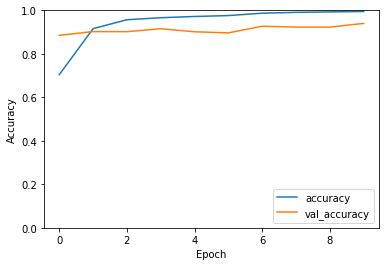

In [6]:
# evaluate the model
plt.plot(lc_history.history['accuracy'], label='accuracy')
plt.plot(lc_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [46]:
p = label_correction_model.predict([X_50000[:], Y_noisy_50000[:]])

In [47]:
with open('/content/drive/MyDrive/Colab Notebooks/5243/label_correction_predictions', 'wb') as fp:
    pickle.dump(p, fp)

In [48]:
y_classes = [np.argmax(element) for element in p]

[6, 9, 9, 4, 1]

In [60]:
y_classes[:5] #prediction value

[6, 9, 9, 4, 1]

In [51]:
with open('/content/drive/MyDrive/Colab Notebooks/5243/lc_classes', 'wb') as fp:
    pickle.dump(y_classes, fp)

In [73]:
import pandas as pd    
df = pd.DataFrame(y_classes)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/5243/cleaned_labels.csv', index=False , header = False)

In [74]:
cleaned_labels = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/5243/cleaned_labels.csv', delimiter=',', dtype="int8") # I changed the path
cleaned_labels

array([6, 9, 9, ..., 9, 1, 1], dtype=int8)

Cleaned labels:
 ship   dog plane  frog truck  bird  ship   cat
Noisy labels:
  car  deer   cat  frog horse  bird horse plane


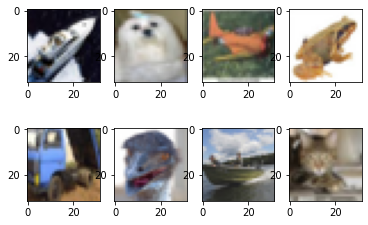

In [70]:
# take a look at some images and check the quality of our cleaned labels

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[20000]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[20001]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[20002]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[20003]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[20004]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[20005]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[20006]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[20007]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Cleaned labels:')
print(' '.join('%5s' % classes[y_classes[j]] for j in range(20000,20008)))

# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(20000,20008)))


In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
y_pred = label_correction_model.predict([X_50000[:8], Y_noisy_50000[:8]])

In [ ]:
# # test. use after getting the test images
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
# print(test_acc)

Reference: 

https://stackoverflow.com/questions/52359905/how-to-feed-and-build-a-input-dense-conv2d-dense-network-in-keras

https://www.programcreek.com/python/example/93296/keras.layers.convolutional.AveragePooling2D

https://medium.com/@pierre.beaujuge/classifying-images-from-the-cifar10-dataset-with-pre-trained-cnns-using-transfer-learning-9348f6d878a8

https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/
